In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.feature_extraction import image
from sklearn.cluster import KMeans
from skimage.filters import rank, threshold_otsu
from skimage.morphology import closing, square, disk
from skimage import exposure as hist, data, img_as_float
from skimage.segmentation import chan_vese
from skimage.feature import canny
from skimage.color import rgb2gray
from scipy import ndimage as ndi

In [2]:
# Load the dataset path to rotten_images and fresh_images
rotten_images = glob("/content/drive/MyDrive/Group_2_ML2_Fruit_Quality_Classification/datasetbanana/rottenbanana/*")
fresh_images = glob("/content/drive/MyDrive/Group_2_ML2_Fruit_Quality_Classification/datasetbanana/freshbanana/*")

In [3]:
# Display the first 5 images
rotten_images_1 = glob("/content/drive/MyDrive/Group_2_ML2_Fruit_Quality_Classification/datasetbanana/rottenbanana/*")[:5]
fresh_images_1 = glob("/content/drive/MyDrive/Group_2_ML2_Fruit_Quality_Classification/datasetbanana/freshbanana/*")[:5]

In [4]:
len(rotten_images)

300

In [5]:
len(fresh_images)

300

In [6]:
# Define preprocessing functions

# Convert gray image to binary image by using Ostu threshold
# Ostu threshold automatically finds the only one suitable threshold for each image after applying K-means to cluster
# --> This is the reason why we choose the banana dataset
def binary(image):
    return image > threshold_otsu(image)

# Equalize the histogram to increase the constrast
def equalize(image):
    return hist.equalize_hist(image)

# Use mean filter to smooth the image (remove noise)
def mean_filter(image, raio_disk):
    return rank.mean_percentile(image, footprint=disk(raio_disk))

# Fill the holes
def preenche_bords(image):
    return ndi.binary_fill_holes(image)

# Load images
def load_images(paths):
    tmp = []
    for path in paths:
        tmp.append(imread(path))
    return tmp

# Plot many images in the same row
def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);

# Plot three channels of images
def plot_camadas(img):
    plt.figure(figsize = (15, 25))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[:,:,i], cmap = 'gray');

# Cluster the gray image by using K-means with k clusters. K-means needs continuous data to calculate Euclidean distance.
def d2Kmeans(img, k):
    return KMeans(
                  random_state=1,
                  n_clusters=k,
                  init='k-means++',
                  n_init=10
    ).fit(img.reshape((-1, 1))).labels_.reshape(img.shape)

# Apply segmentation mask to original RGB image
# uri_img: original RGB image
# img_kluster: clustering mask — is a grayscale image clustered using KMeans (cluster labels are 0, 1, 2, …)
# Apply clustering mask for each channel
def merge_segmented_mask_ROI(uri_img, img_kluster):
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:,:, ch] *= img_kluster
    return new_img

# Plot the Elbow diagram to find the best k-clusters
def elbow(img, k):
    hist = []
    for kclusters in  range(1, k):
        Km = KMeans(random_state=1, n_clusters=kclusters, init='k-means++').fit(img.reshape((-1,1)))
        hist.append(Km.inertia_)

    plt.figure(figsize = (15, 8))
    plt.grid()
    plt.plot(range(1, k), hist, 'o-')
    plt.ylabel('Sum of squares of distance')
    plt.xlabel('k clusters')
    plt.title('Elbow')
    plt.show();

In [7]:
# Load images
rotten = load_images(rotten_images)
fresh = load_images(fresh_images)

rotten_1 = load_images(rotten_images_1)
fresh_1 = load_images(fresh_images_1)

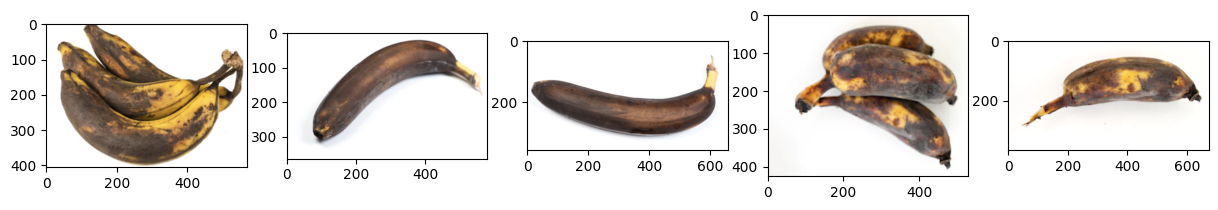

In [8]:
plot_any(rotten_1)

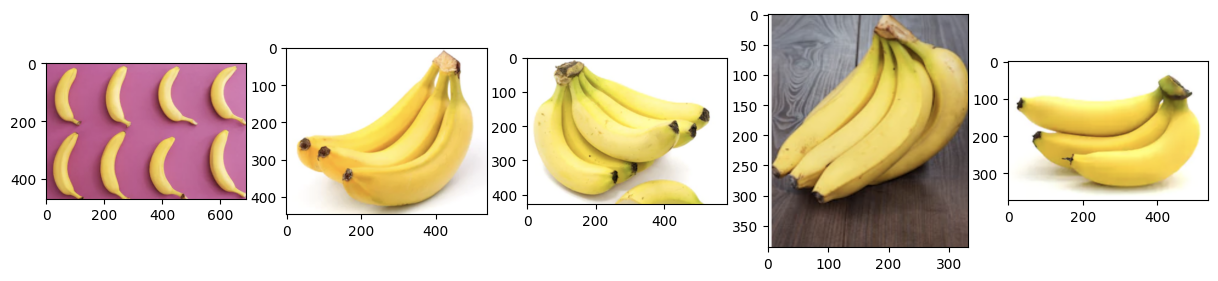

In [9]:
plot_any(fresh_1)

In [10]:
img_selected = rotten[1]

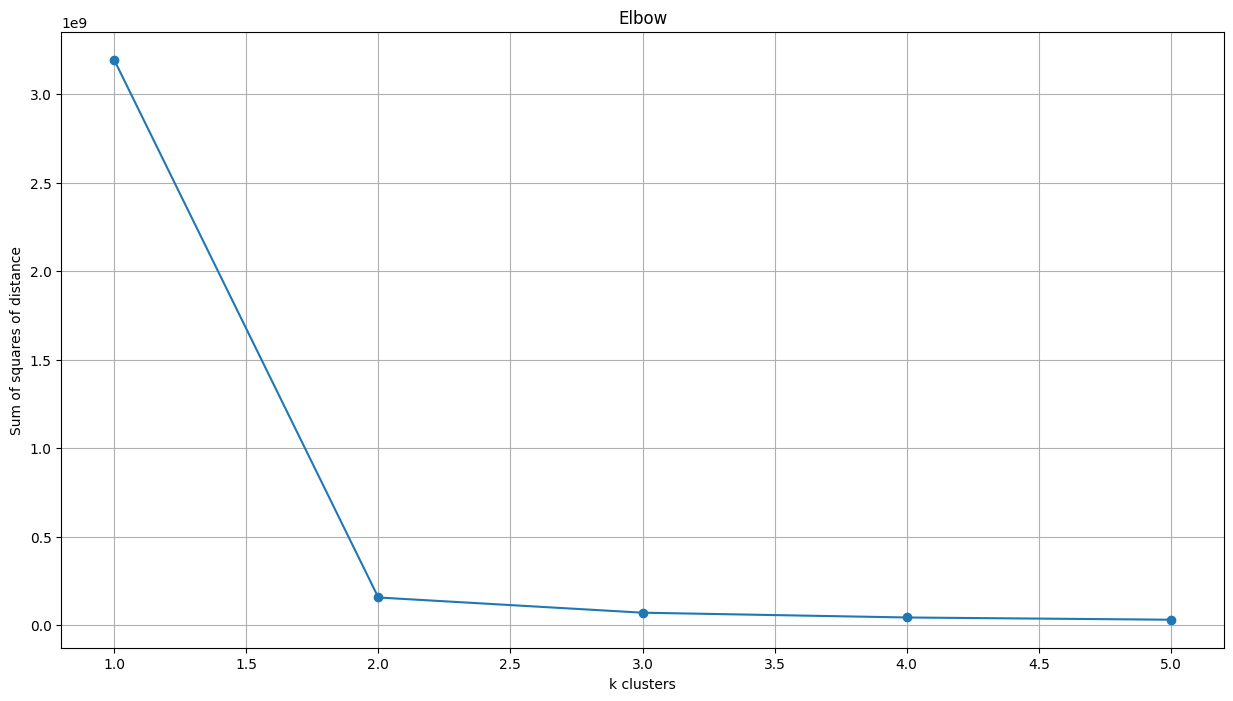

In [11]:
elbow(img_selected, 6)

In [12]:
k_klusters = 2

In [13]:
# Grayscale image clustering, each pixel is assigned a label: 0 or 1 (k_klusters = 2)
result_gray = d2Kmeans(rgb2gray(img_selected), k_klusters)
# RGB image clustering
result_img = d2Kmeans(img_selected, k_klusters)

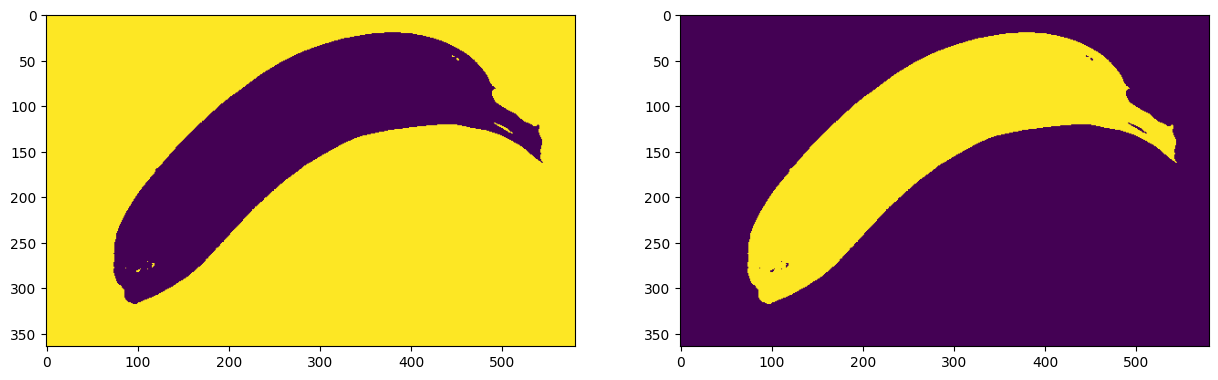

In [14]:
# A loop to create masks (True/ False) corresponding to labels (clusters)
klusters_gray = [result_gray == i for i in range(k_klusters)]
# Plot each mask
plot_any(klusters_gray)

In [15]:
# Choose the darkness cluster --> detect rotten banana
# 'clusters' is the list of mask
def select_cluster_index(clusters):
    # Initialize initial value
    minx = clusters[0].mean()
    index = 0
    # Browse/ Check each cluster
    for i in clusters:
        if i.mean() < minx:
            minx = i.mean()
            index += 1
    return index
# i: index of mask (True/ False) in each cluster
# index: index of cluster

In [16]:
# Print the good cluster
index_kluster = select_cluster_index(klusters_gray)
print(index_kluster)
# Focus on the darkness cluster
selecionado = klusters_gray[index_kluster]

1


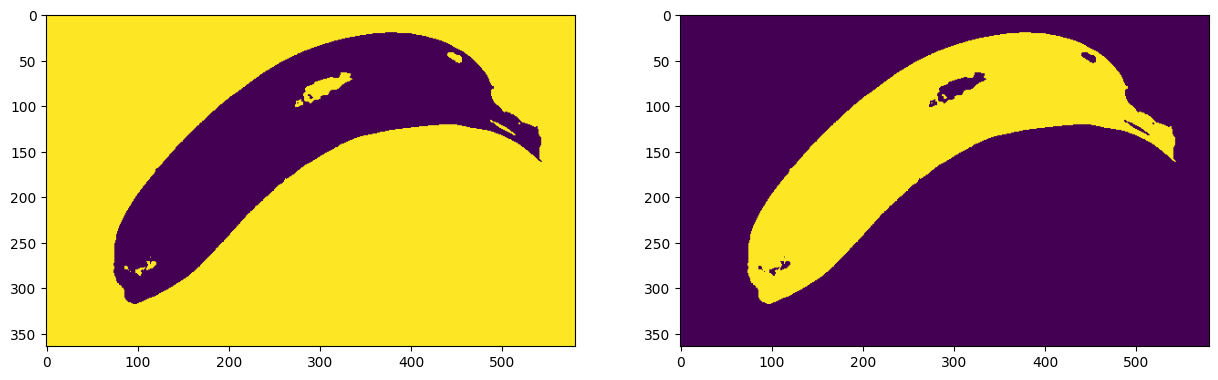

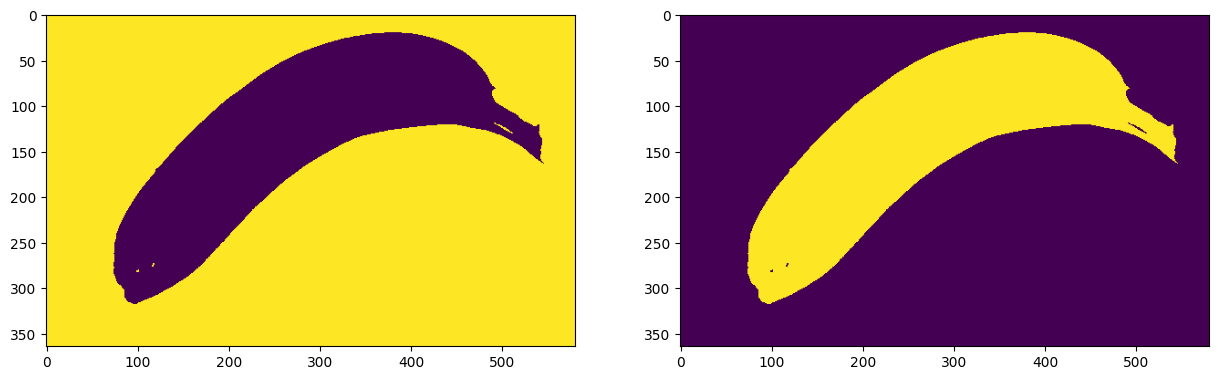

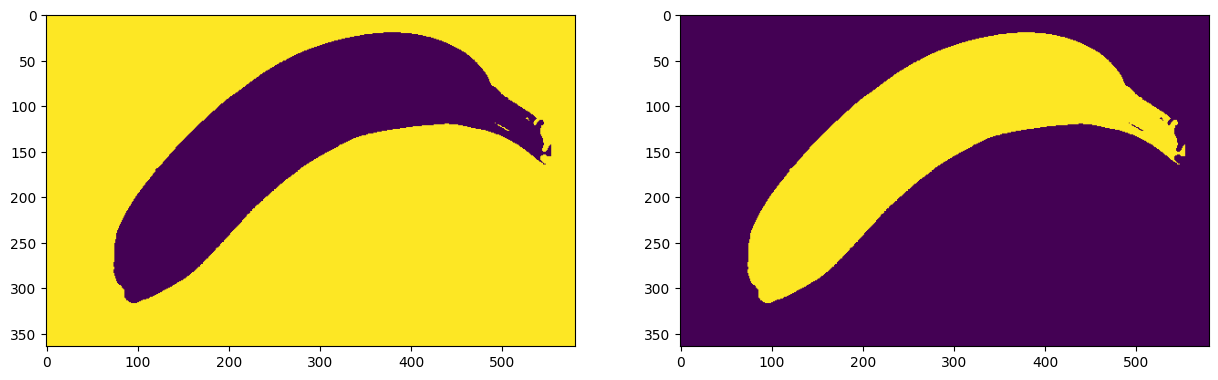

In [17]:
 # Create mask for each color channel
 for ch in range(3):
    img_k = []
    for K in range(k_klusters):
         img_k.append(result_img[:, :, ch] == K)
    plot_any(img_k)

In [18]:
# Recreate mask in the green channel, because banana is yellow and a little green, almost banana's pixels have the high value at G channel
clusters = [(result_img[:,:,1] == K) for K in range(k_klusters)]

In [19]:
# Print array of masks
clusters
# The selected image is completely rotten, so after clustering, the first array is almost True, and the second array is almost False.

[array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])]

In [20]:
# Apply segmentation mask (which is selecionado) to original RGB image (which is img_selected)
# Apply clustering mask for each channel
new_img = merge_segmented_mask_ROI(img_selected, selecionado)
# True (1), False (0) --> part which is not rotten becomes black

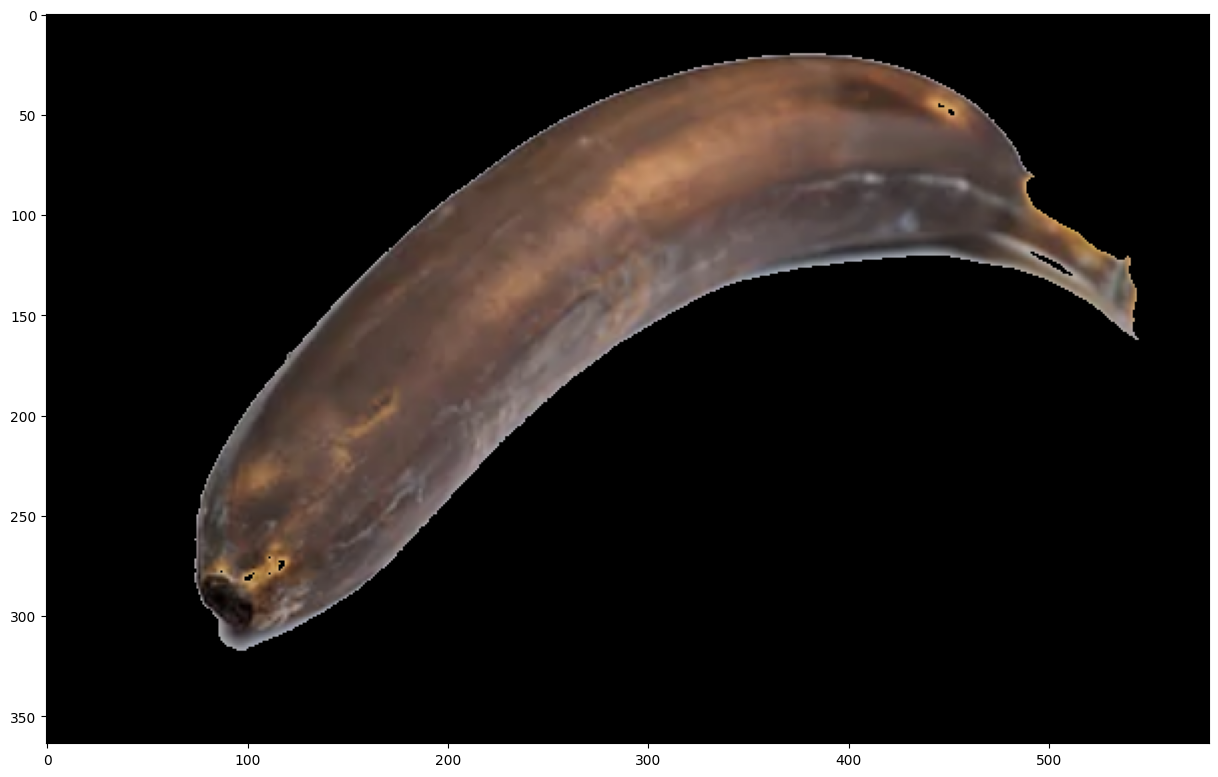

In [21]:
plot_any([new_img])

In [22]:
from skimage.util import img_as_ubyte

# Pre-process the mask, because the original mask is True/ False (boolean array)
# Convert to 8-bit integer, because there are some function need this format
selecionado_uint8 = img_as_ubyte(selecionado)

# Apply mean_filter with kernel 20x20
image_mean_filter = mean_filter(selecionado_uint8, 20)
# Convert smoothed image into binary image by threshold
test_binary = binary(image_mean_filter)

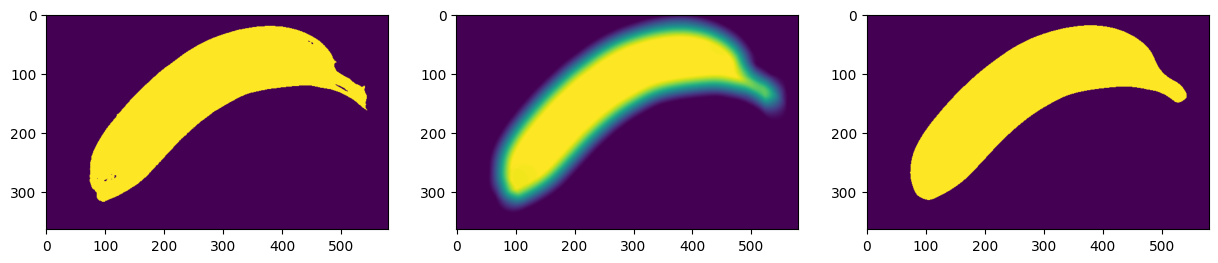

In [23]:
plot_any([selecionado, image_mean_filter, test_binary])

In [24]:
# Apply binary mask (which is test_binary) to original RGB image (which is img_selected)
# Apply clustering mask for each channel
final_result = merge_segmented_mask_ROI(img_selected, test_binary)

In [25]:
final_result.shape

(364, 580, 3)

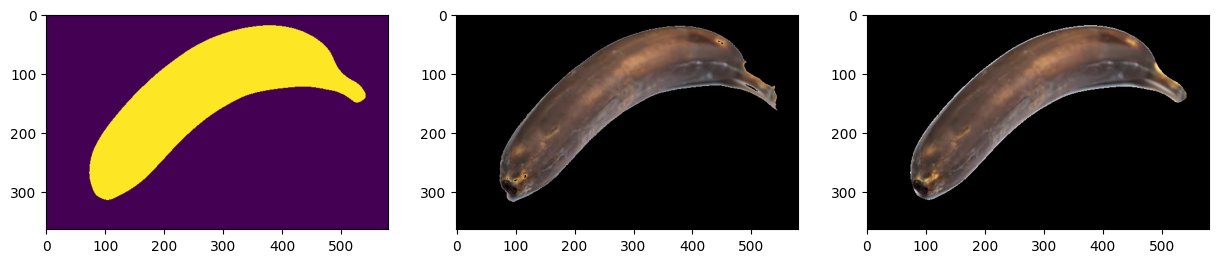

In [26]:
plot_any([test_binary, new_img, final_result])

In [27]:
import cv2

data_rotten = list()

for img in rotten:
    img_resized = cv2.resize(img, (600, 400))
    img_gray = rgb2gray(img_resized)
    img_gray_uint8 = img_as_ubyte(img_gray)
    img_mean = mean_filter(img_gray_uint8, 20)
    img_binary = binary(img_mean)
    img_masked = merge_segmented_mask_ROI(img_resized, img_binary)
    data_rotten.append(img_masked)

In [28]:
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

data_fresh = list()

for img in fresh:
    img_resized = cv2.resize(img, (600, 400))
    img_gray = rgb2gray(img_resized)
    img_gray_uint8 = img_as_ubyte(img_gray)
    img_mean = mean_filter(img_gray_uint8, 20)
    img_binary = binary(img_mean)
    img_masked = merge_segmented_mask_ROI(img_resized, img_binary)
    data_fresh.append(img_masked)

In [ ]:
len(data_rotten)

300

In [ ]:
len(data_fresh)

300

In [29]:
import cv2
import os
import io
import skimage
# Create a directory in which to store images which are masked
out_dir = "/kaggle/working/skin_seg"
# If the folder haven't created, create
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# sSave each image by its index number
for k,im in enumerate(data_fresh):
    skimage.io.imsave( 'fresh' + str(k) + ".png", im)

In [30]:
# Create a directory in which to store images which are masked
out_dir = "/kaggle/working/skin_seg"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Save each image by its index number
for c,image in enumerate(data_rotten):
    skimage.io.imsave( 'rotten' + str(c) + ".png", image)

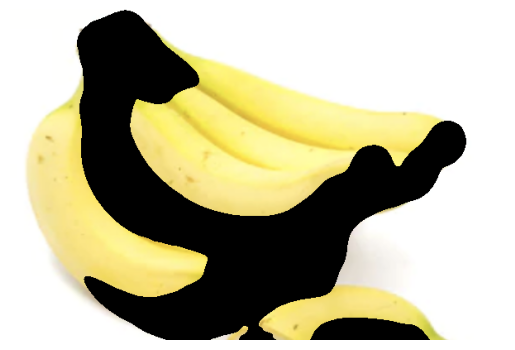

In [40]:
# Show the image with mask
plt.imshow(data_fresh[2])
plt.axis('off')
plt.show()

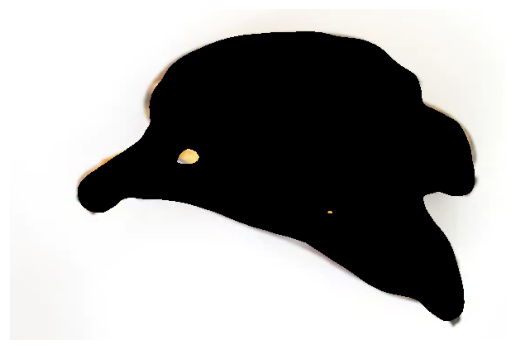

In [37]:
# Show the image with mask
plt.imshow(data_rotten[3])
plt.axis('off')
plt.show()

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

from skimage.io import imread
from skimage.transform import resize

In [ ]:
def load_image_files(container_path, dimension=(28, 28)):
    """
    Load image files with categories as subfolder names
    which performs like scikit-learn sample dataset

    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    dimension : tuple
        size to which image are adjusted to

    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = [] # List of matrix image
    flat_data = [] # List of vector image
    target = [] # Label
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            img = skimage.io.imread(file)
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            flat_data.append(img_resized.flatten())
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)
    images.reshape((-1, 1, 28, 28))

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [ ]:
!pip install keras

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.constraints import MaxNorm
from keras.utils import to_categorical
import sklearn

In [ ]:
image_dataset = load_image_files("/content/drive/MyDrive/Group_2_ML2_Fruit_Quality_Classification/datasetbanana")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset.data, image_dataset.target, test_size=0.2,random_state=42)

In [ ]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
# All processed image (vector) are used as input of Random Forest to classify rotten or fresh

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
print(clf)

RandomForestClassifier()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [ ]:
from sklearn.model_selection import train_test_split
# Train RF by X-train (vector images) and y_train(corresponding label)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score
# Predict label for test set
preds = clf.predict(X_test)
# Calculate accuracy
print("Accuracy:", accuracy_score(y_test,preds))

Accuracy: 0.975


In [ ]:
print(X_train.shape)
print(X_test.shape )
print(y_train.shape )
print(y_test.shape)

(480, 2352)
(120, 2352)
(480,)
(120,)


In [ ]:
# Split the traing set to train + validation
# --> Evaluate the model (do not use the test set)
x_train, x_test, y_train_v, y_test_v = train_test_split(X_train,y_train, test_size = 0.2, random_state = 2)

In [ ]:
# Create new RF model
rf = RandomForestClassifier()

# Train
rf.fit(x_train,y_train_v)
# Predictions on training
y_pred_train = rf.predict(x_train)
# Predictions for validation
y_pred_test = rf.predict(x_test)
# training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train_v, y_pred= y_pred_train))

# validation data metrics
print("Validation data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test_v, y_pred= y_pred_test))

Training metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       1.00      1.00      1.00       188

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384

Test data metrics:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        42
           1       0.96      0.94      0.95        54

    accuracy                           0.95        96
   macro avg       0.95      0.95      0.95        96
weighted avg       0.95      0.95      0.95        96



In [ ]:
# Print the labels which is the model learn
print(rf.classes_)

[0 1]


In [ ]:
from PIL import Image
import time
from torch.autograd import Variable
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

from skimage.transform import resize

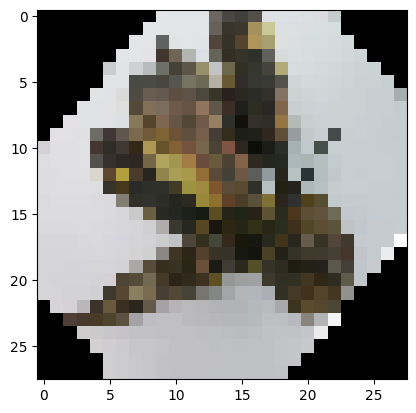

In [ ]:
img_path="/content/drive/MyDrive/Group_2_ML2_Fruit_Quality_Classification/dataset/rottenbanana/rotated_by_45_Screen Shot 2018-06-12 at 8.57.14 PM.png"
img_ = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_ = cv2.resize(img_, (28, 28))
img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
plt.imshow(img_)

In [ ]:
!pip install mahotas
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import mahotas
import cv2
import os
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Make a fix file size
fixed_size  = tuple((1000,1000))

# Train path
train_path = "/content/drive/MyDrive/Group_2_ML2_Fruit_Quality_Classification/datasetbanana"

# No. of trees for Random Forests
num_tree = 100

# Bins for histograms
bins = 8

# Train_test_split size
test_size = 0.10

# Seed for reproducing same result
seed = 9

In [ ]:
# High-level features

In [ ]:
# Learn shape
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:
# Learn texture
# Feature-descriptor -2 Haralick Texture

def fd_haralick(image):
    # conver the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Ccompute the haralick texture fetature ve tor
    haralic = mahotas.features.haralick(gray).mean(axis=0)
    return haralic

In [ ]:
# Learn color
# Feature-description -3 Color Histogram

def fd_histogram(image, mask=None):
    # Conver the image to HSV colors-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # COPUTE THE COLOR HISTPGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[bins,bins,bins], [0, 256, 0, 256, 0, 256])
    # Normalize the histogram
    cv2.normalize(hist,hist)
    # Return the histog....
    return hist.flatten()

In [ ]:
# Get the training data labels
train_labels = os.listdir(train_path)

# Sort the training labesl
train_labels.sort()
print(train_labels)

# Empty list to hold feature vectors and labels
global_features = []
labels = []

i, j = 0, 0
k = 0

['freshbanana', 'rottenbanana']


In [ ]:
# Ittirate the folder to get the image label name

%time
# Lop over the training data sub folder

for training_name in train_labels:
    # Join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # Get the current training label
    current_label = training_name

    k = 1
    # Loop over the images in each sub-folder

    for file in os.listdir(dir):

        file = dir + "/" + os.fsdecode(file)

        # Read the image and resize it to a fixed-size
        image = cv2.imread(file)

        if image is not None:
            image = cv2.resize(image,fixed_size)
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
        #else:
            #print("image not loaded")

        #image = cv2.imread(file)
        #image = cv2.resize(image,fixed_size)

        # Concatenate global features
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # Update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

        i += 1
        k += 1
    print("[STATUS] processed folder: {}".format(current_label))
    j += 1

print("[STATUS] completed Global Feature Extraction...")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 14.3 µs
[STATUS] processed folder: freshbanana
[STATUS] processed folder: rottenbanana
[STATUS] completed Global Feature Extraction...


In [ ]:
%time
# Get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# Get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# Encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...{}")
# Normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
[STATUS] feature vector size (600, 532)
[STATUS] training Labels (600,)
[STATUS] training labels encoded...{}
[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1

In [ ]:
global_features = np.array(rescaled_features)
global_labels = np.array(target)

In [ ]:
# Split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

In [ ]:
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100)

# Fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# Print(clf.fit(trainDataGlobal, trainLabelsGlobal))

clf_pred = clf.predict(trainDataGlobal)
#clf_pred = clf.predict(global_feature.reshape(1,-1))[0]
print(classification_report(trainLabelsGlobal,clf_pred))
y_pred_test = clf.predict(testDataGlobal)

print(classification_report(testLabelsGlobal,y_pred_test))
#print(confusion_matrix(trainLabelsGlobal,clf_pred))

#print(clf.predict(trainDataGlobal))

#print(clf.predict(global_feature.reshape(1,-1))[0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00       272

    accuracy                           1.00       540
   macro avg       1.00      1.00      1.00       540
weighted avg       1.00      1.00      1.00       540

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.96      0.98        28

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



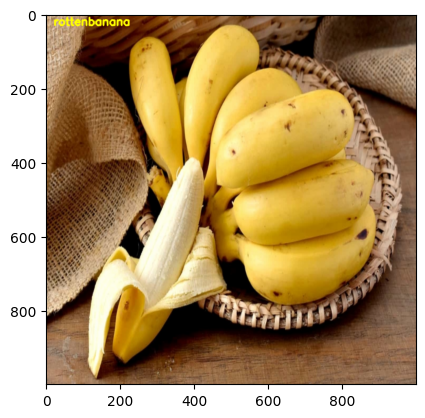

In [ ]:
test_path = "/content/drive/MyDrive/Group_2_ML2_Fruit_Quality_Classification/chuoi.jpg"


    #print(file)

image = cv2.imread(test_path)
image = cv2.resize(image, fixed_size)

    # Global Feature extraction
fv_hu_moments = fd_hu_moments(image)
fv_haralick   = fd_haralick(image)
fv_histogram  = fd_histogram(image)

    # Concatenate global features

global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # Predict label of test image
prediction = clf.predict(global_feature.reshape(1,-1))[0]

    # Show predicted label on image
cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # Display the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
data.to_csv(r'df_name.csv')

In [ ]:
from IPython.display import FileLink
FileLink(r'df_name.csv')